In [1]:
#Data Manipulation Library
import numpy as np
import pandas as pd
%matplotlib inline

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
#ML models:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
#Import dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('gender_submission.csv')


In [3]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
#merge train and test data to work on data preparation (e.g missing data, normalization etc)
titanic = train.append(test, ignore_index = True)
#The last 5 rows of the data
titanic.tail() 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
1308,1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [6]:
#feature information
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [7]:
print('There are total {} unique Name.'.format(len(titanic.Name.unique())))

There are total 1307 unique Name.


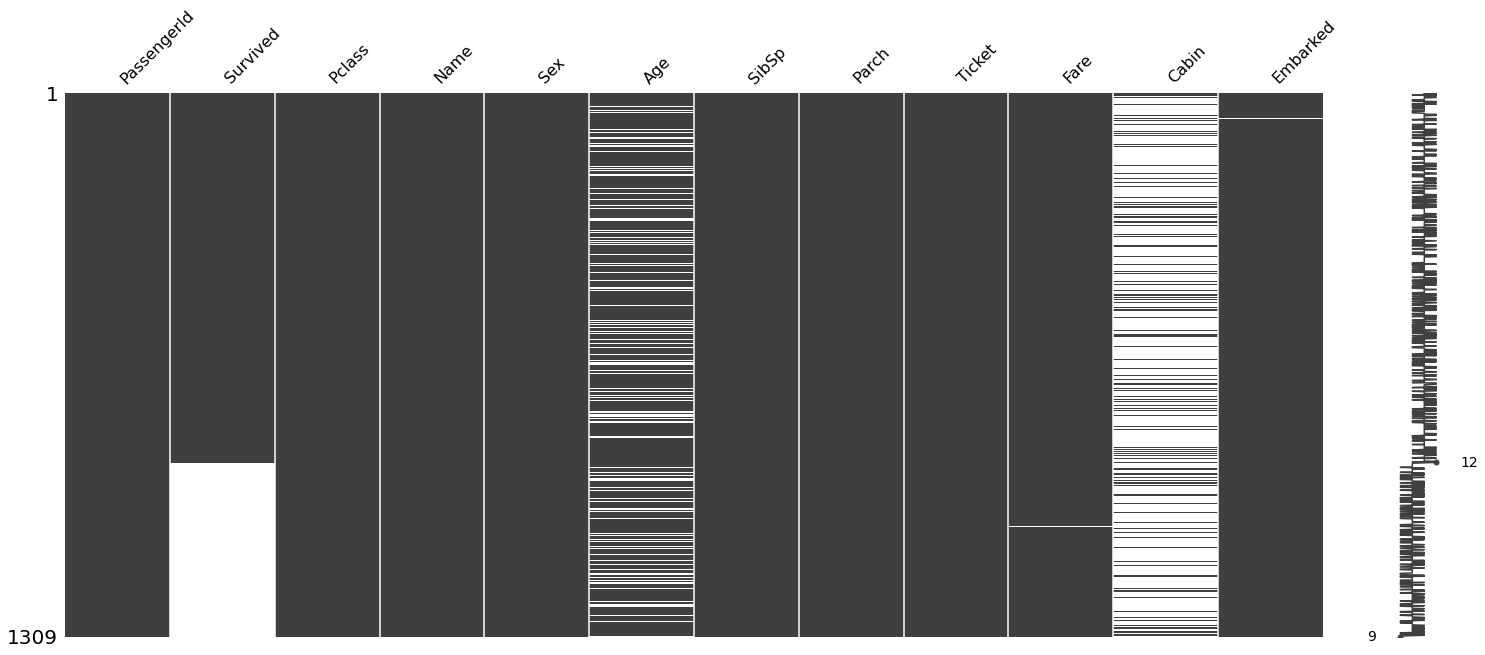

In [8]:
missingno.matrix(titanic)

In [9]:
titanic.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [10]:
#create a new feature to extract title names form Name
titanic['NameTitle'] = titanic.Name.apply(lambda name: 
                                      name.split(',')[1].split('.')[0].strip())

len(titanic.NameTitle.unique()), titanic.NameTitle.unique()

(18,
 array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
        'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
        'Jonkheer', 'Dona'], dtype=object))

####  we see there are only 18 different title. We will generalize a bit more to put into 6 larger gategories and then map that dictionary back to the NameTitle feature

In [11]:
#Normalize the NameTitle
normalized_NameTitles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"
}

#map the normalized titles to the current titles
titanic.NameTitle = titanic.NameTitle.map(normalized_NameTitles)

#view value counts fro the normalized titles
print(titanic.NameTitle.value_counts())

Mr         757
Miss       262
Mrs        200
Master      61
Officer     23
Royalty      6
Name: NameTitle, dtype: int64


#### Now we can use the NameTitle feature to estimate the missing ages.  

In [12]:
#group by Sex, Pclass and Title
grouped = titanic.groupby(['Sex', 'Pclass', 'NameTitle'])

#view the median Age by the grouped features
grouped.Age.median()

Sex     Pclass  NameTitle
female  1       Miss         30.0
                Mrs          45.0
                Officer      49.0
                Royalty      39.0
        2       Miss         20.0
                Mrs          30.0
        3       Miss         18.0
                Mrs          31.0
male    1       Master        6.0
                Mr           41.5
                Officer      52.0
                Royalty      40.0
        2       Master        2.0
                Mr           30.0
                Officer      41.5
        3       Master        6.0
                Mr           26.0
Name: Age, dtype: float64

####  Now we will use grouped.Age variable to fill in the missing values for Age, which will give better approximation of age intead of just using Age mean or median values

In [13]:
#apply the grouped meadian values on the Age Nan
titanic.Age = grouped.Age.apply(lambda x: x.fillna(x.median))
titanic.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
NameTitle         0
dtype: int64

####  Now we will work on the missing values of Fare, Cabin, Embarked

In [14]:
#fill Cabin NaN with U for unknown
titanic.Cabin = titanic.Cabin.fillna('U')

#find most frquent Embarked.value_counts().index[0]
most_embarked = titanic.Embarked.value_counts().index[0]

#fill Nan with most_embaked value
titanic.Embarked = titanic.Embarked.fillna(most_embarked)

#fill NaN with median fare
titanic.Fare = titanic.Fare.fillna(titanic.Fare.median())

#view cahnges
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   object 
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1309 non-null   object 
 12  NameTitle    1309 non-null   object 
dtypes: float64(2), int64(4), object(7)
memory usage: 133.1+ KB


In [15]:
titanic.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         0
NameTitle        0
dtype: int64

In [16]:
#size of families(including the passenger)
titanic['FamilySize'] = titanic.Parch + titanic.SibSp + 1
titanic.FamilySize.unique()

array([ 2,  1,  5,  3,  7,  6,  4,  8, 11], dtype=int64)

In [17]:
#map first letter of cabin to itself
titanic.Cabin = titanic.Cabin.map(lambda x: x[0])

In [18]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NameTitle,FamilySize
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,U,S,Mr,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,C,Mrs,2
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,U,S,Miss,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C,S,Mrs,2
4,5,0.0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,U,S,Mr,1


In [19]:
#conver the male and female groups to integer form
titanic['Sex'] = np.where(titanic['Sex'] == 'female', 1, 0)

#create dummy variables for categorical features
Pclass_dummies = pd.get_dummies(titanic.Pclass, prefix = 'Pclass')
NameTitle_dummies = pd.get_dummies(titanic.NameTitle, prefix = 'NameTitle')
Cabin_dummies = pd.get_dummies(titanic.Cabin, prefix = 'Cabin')
Embarked_dummies = pd.get_dummies(titanic.Embarked, prefix = 'Embarked')

#concatenate dummy columns with main dataset
titanic_dummies = pd.concat([titanic, 
                             Pclass_dummies, 
                             NameTitle_dummies,
                             Cabin_dummies, 
                             Embarked_dummies], axis = 1)

#drop categorical fields
titanic_dummies.drop(['Pclass', 'NameTitle', 'Cabin', 'Embarked',
                     'Name', 'Ticket'], axis = 1, inplace = True)

titanic_dummies.head()


,PassengerId,Survived,Sex,Age,SibSp,Parch,Fare,FamilySize,Pclass_1,Pclass_2,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Embarked_C,Embarked_Q,Embarked_S
0,1,0.0,0,22,1,0,7.2500,2,0,0,...,0,0,0,0,0,0,1,0,0,1
1,2,1.0,1,38,1,0,71.2833,2,1,0,...,1,0,0,0,0,0,0,1,0,0
2,3,1.0,1,26,0,0,7.9250,1,0,0,...,0,0,0,0,0,0,1,0,0,1
3,4,1.0,1,35,1,0,53.1000,2,1,0,...,1,0,0,0,0,0,0,0,0,1
4,5,0.0,0,35,0,0,8.0500,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [21]:
#Separate train and test data
train = titanic_dummies[:len(train)]
test = titanic_dummies[len(train):]

#Convert Survived back to integer
train.Survived = train.Survived.astype(int)


C:\Users\afroj\Anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [22]:
x = train.drop('Survived', axis = 1)
y = train.Survived

x_test = test.drop('Survived', axis = 1)


In [23]:

#create X, y for the train input and train lavel
X = train.drop('Survived', axis = 1).values
yy = train.Survived.values

#create array for test set
X_test = test.drop('Survived', axis = 1).values

In [24]:
#Modeling
forrest_params = dict(     
    max_depth = [n for n in range(9, 14)],     
    min_samples_split = [n for n in range(4, 11)], 
    min_samples_leaf = [n for n in range(2, 5)],     
    n_estimators = [n for n in range(10, 60, 10)],
)
forrest_params

{'max_depth': [9, 10, 11, 12, 13],
 'min_samples_split': [4, 5, 6, 7, 8, 9, 10],
 'min_samples_leaf': [2, 3, 4],
 'n_estimators': [10, 20, 30, 40, 50]}

In [26]:
#instantiate random forest model
forrest = RandomForestClassifier()

#build and fit the model
forest_cv = GridSearchCV(estimator=forrest,     
                         param_grid=forrest_params, 
                         cv=5)



In [28]:
forest_cv.fit(x, y)

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: float() argument must be a string or a number, not 'method'

  FitFailedWarning)
C:\Users\afroj\Anaconda3\lib\site-packages\sklearn\model_selection\_valid

TypeError: float() argument must be a string or a number, not 'method'

In [ ]:
print('Best score:{} \n Optimal params:{}'.format(forest_cv.best_score_, 
                                                  forest_cv.best_estimator_))

In [ ]:
#random forrest prediction on test set
pred = forest_cv.predict(X_test)

In [ ]:
submissionFile = pd.DataFrame({'PassengerId': test.PassengerId,
                              'Survived': pred})

#save to csv
submissionFile.to_csv('submissionFile.csv')
submissionFile.head()